In [6]:
import pandas as pd
import numpy as np
import cupy as cp
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Load dataset and consider only 5,000 records
df = pd.read_csv('vaccine_sample.csv').head(5000)

# Clean up column names
df.columns = df.columns.str.strip()

# Convert 'user_followers' to numeric (if needed)
df['user_followers'] = pd.to_numeric(df['user_followers'], errors='coerce').fillna(0)

# Extract relevant columns
df = df[['user_name', 'user_followers', 'is_retweet', 'user_verified', 'user_friends', 'user_favourites', 'hashtags']]

# Remove retweets for this analysis
df = df[df['is_retweet'] == False]

# Map user_name to an index for parallel processing
user_names = df['user_name'].unique()
user_index = {name: i for i, name in enumerate(user_names)}

# Create adjacency matrix for PageRank
n = len(user_names)
adj_matrix = cp.zeros((n, n))

# Populate adjacency matrix based on user interactions (followers)
for index, row in df.iterrows():
    user_idx = user_index[row['user_name']]
    followers = row['user_followers']

    # Add followers interaction (consider followers > 0)
    if followers > 0:
        for follower in df['user_name']:
            follower_idx = user_index[follower]
            adj_matrix[follower_idx, user_idx] += followers  # Consider follower interaction

# Normalize adjacency matrix row-wise
row_sums = cp.sum(adj_matrix, axis=1)
row_sums[row_sums == 0] = 1  # Avoid division by zero
adj_matrix = adj_matrix / row_sums[:, cp.newaxis]


In [7]:
# Serial PageRank function (using NumPy)
def pagerank_serial(M, num_iterations: int = 100, d: float = 0.85):
    N = M.shape[1]
    ranks = np.ones(N) / N  # Start with equal rank for each user
    for _ in range(num_iterations):
        ranks = (1 - d) / N + d * M.T @ ranks  # PageRank update rule
    return ranks

# Parallel PageRank function (using CuPy)
def pagerank_parallel(M, num_iterations: int = 100, d: float = 0.85):
    N = M.shape[1]
    ranks = cp.ones(N) / N  # Start with equal rank for each user
    for _ in range(num_iterations):
        ranks = (1 - d) / N + d * M.T @ ranks  # PageRank update rule
    return ranks


In [8]:
# --- Timing the Serial Computation (CPU with NumPy) ---
import time
start_time_serial = time.time()
pagerank_scores_serial = pagerank_serial(adj_matrix.get())  # Convert CuPy to NumPy for serial computation
end_time_serial = time.time()

# --- Timing the Parallel Computation (GPU with CuPy) ---
start_time_parallel = time.time()
pagerank_scores_parallel = pagerank_parallel(adj_matrix)  # Use CuPy directly for parallel computation
end_time_parallel = time.time()

# Calculate execution times
serial_time = end_time_serial - start_time_serial
parallel_time = end_time_parallel - start_time_parallel

print(f"Serial computation (NumPy) took: {serial_time:.4f} seconds")
print(f"Parallel computation (CuPy) took: {parallel_time:.4f} seconds")

# Calculate speedup
speedup = serial_time / parallel_time if parallel_time != 0 else float('inf')
print(f"Speedup (Serial / Parallel): {speedup:.2f}")


Serial computation (NumPy) took: 4.0703 seconds
Parallel computation (CuPy) took: 0.0279 seconds
Speedup (Serial / Parallel): 146.12


In [14]:
# Sort top users by PageRank scores (Parallel version)
top_10_indices = cp.argsort(pagerank_scores_parallel)[-10:]
top_10_users = [user_names[idx] for idx in top_10_indices.get()]
top_10_scores = [pagerank_scores_parallel[idx] for idx in top_10_indices.get()]

# Convert CuPy arrays in top_10_scores to NumPy arrays and flatten them
top_10_scores = [score.get().item() for score in top_10_scores]

# Plot top 10 users and their PageRank scores (Bar Chart)
fig = go.Figure(data=[go.Bar(
    x=top_10_users,
    y=top_10_scores,
    marker=dict(color='blue'),
)])

# Show the figure
fig.show()


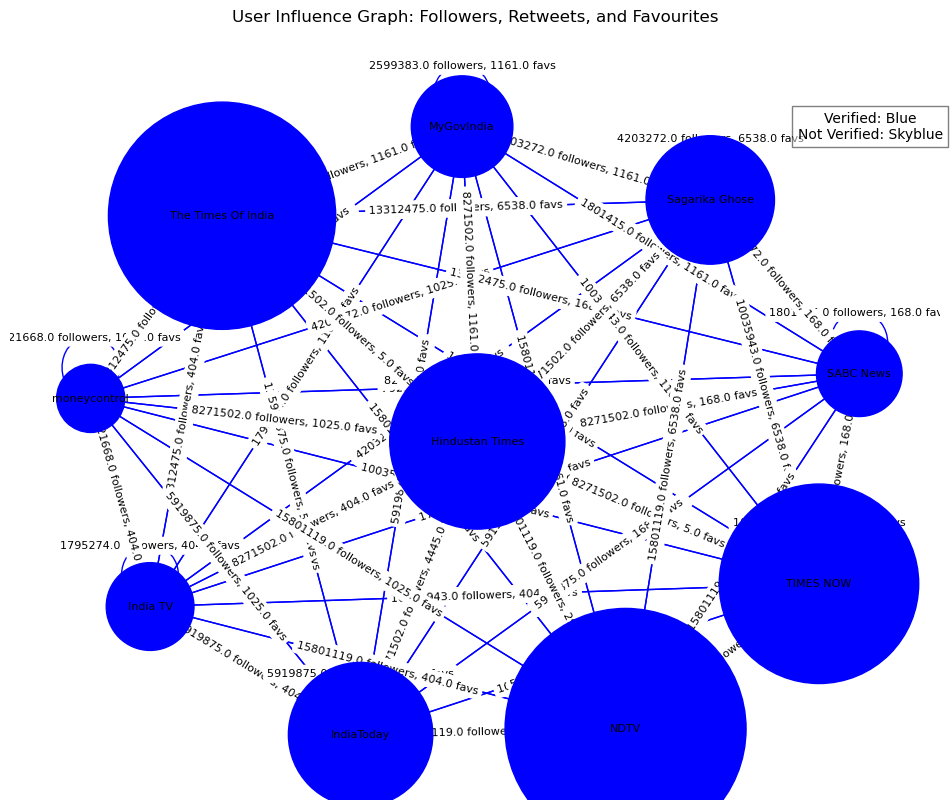

In [15]:
# ---- NetworkX Visualization ---- #
G = nx.DiGraph()

# Add nodes for the top 10 users
for user in top_10_users:
    user_data = df[df['user_name'] == user].iloc[0]
    G.add_node(user, followers=user_data['user_followers'], verified=user_data['user_verified'])

# Add edges based on interactions (followers > 0 and top 10 users)
for index, row in df.iterrows():
    if row['user_name'] in top_10_users:
        retweeter = row['user_name']
        followers = df[df['user_followers'] > 0]  # Ensure follower count > 0

        for _, follower_row in followers.iterrows():
            follower = follower_row['user_name']
            if follower in top_10_users:
                G.add_edge(follower, retweeter,
                           followers=follower_row['user_followers'],
                           is_retweet=row['is_retweet'],
                           favourites=row['user_favourites'])

# Adjusted graph visualization to reduce node overlap
plt.figure(figsize=(12, 10))

# Spring layout for network graph
pos = nx.spring_layout(G, k=1.2, seed=42)  # k controls the distance between nodes

# Node size based on followers
node_sizes = [150 + (G.nodes[node]['followers'] / 500) for node in G.nodes]
node_colors = ['blue' if G.nodes[node]['verified'] else 'skyblue' for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)

# Edge colors based on retweets
edges = G.edges(data=True)
edge_colors = ['green' if edge_data['is_retweet'] else 'blue' for _, _, edge_data in edges]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowstyle='->', arrowsize=10)

# Labels for nodes (user names)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

# Edge labels (followers count and favourites)
edge_labels = {(u, v): f"{d['followers']} followers, {d['favourites']} favs" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Legend for verification status
plt.text(1, 1, "Verified: Blue\nNot Verified: Skyblue", horizontalalignment='center', verticalalignment='center',
         bbox=dict(facecolor='white', alpha=0.5), fontsize=10)

# Title and show plot
plt.title("User Influence Graph: Followers, Retweets, and Favourites")
plt.axis('off')  # Hide axis
plt.show()
